# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

21


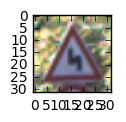

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

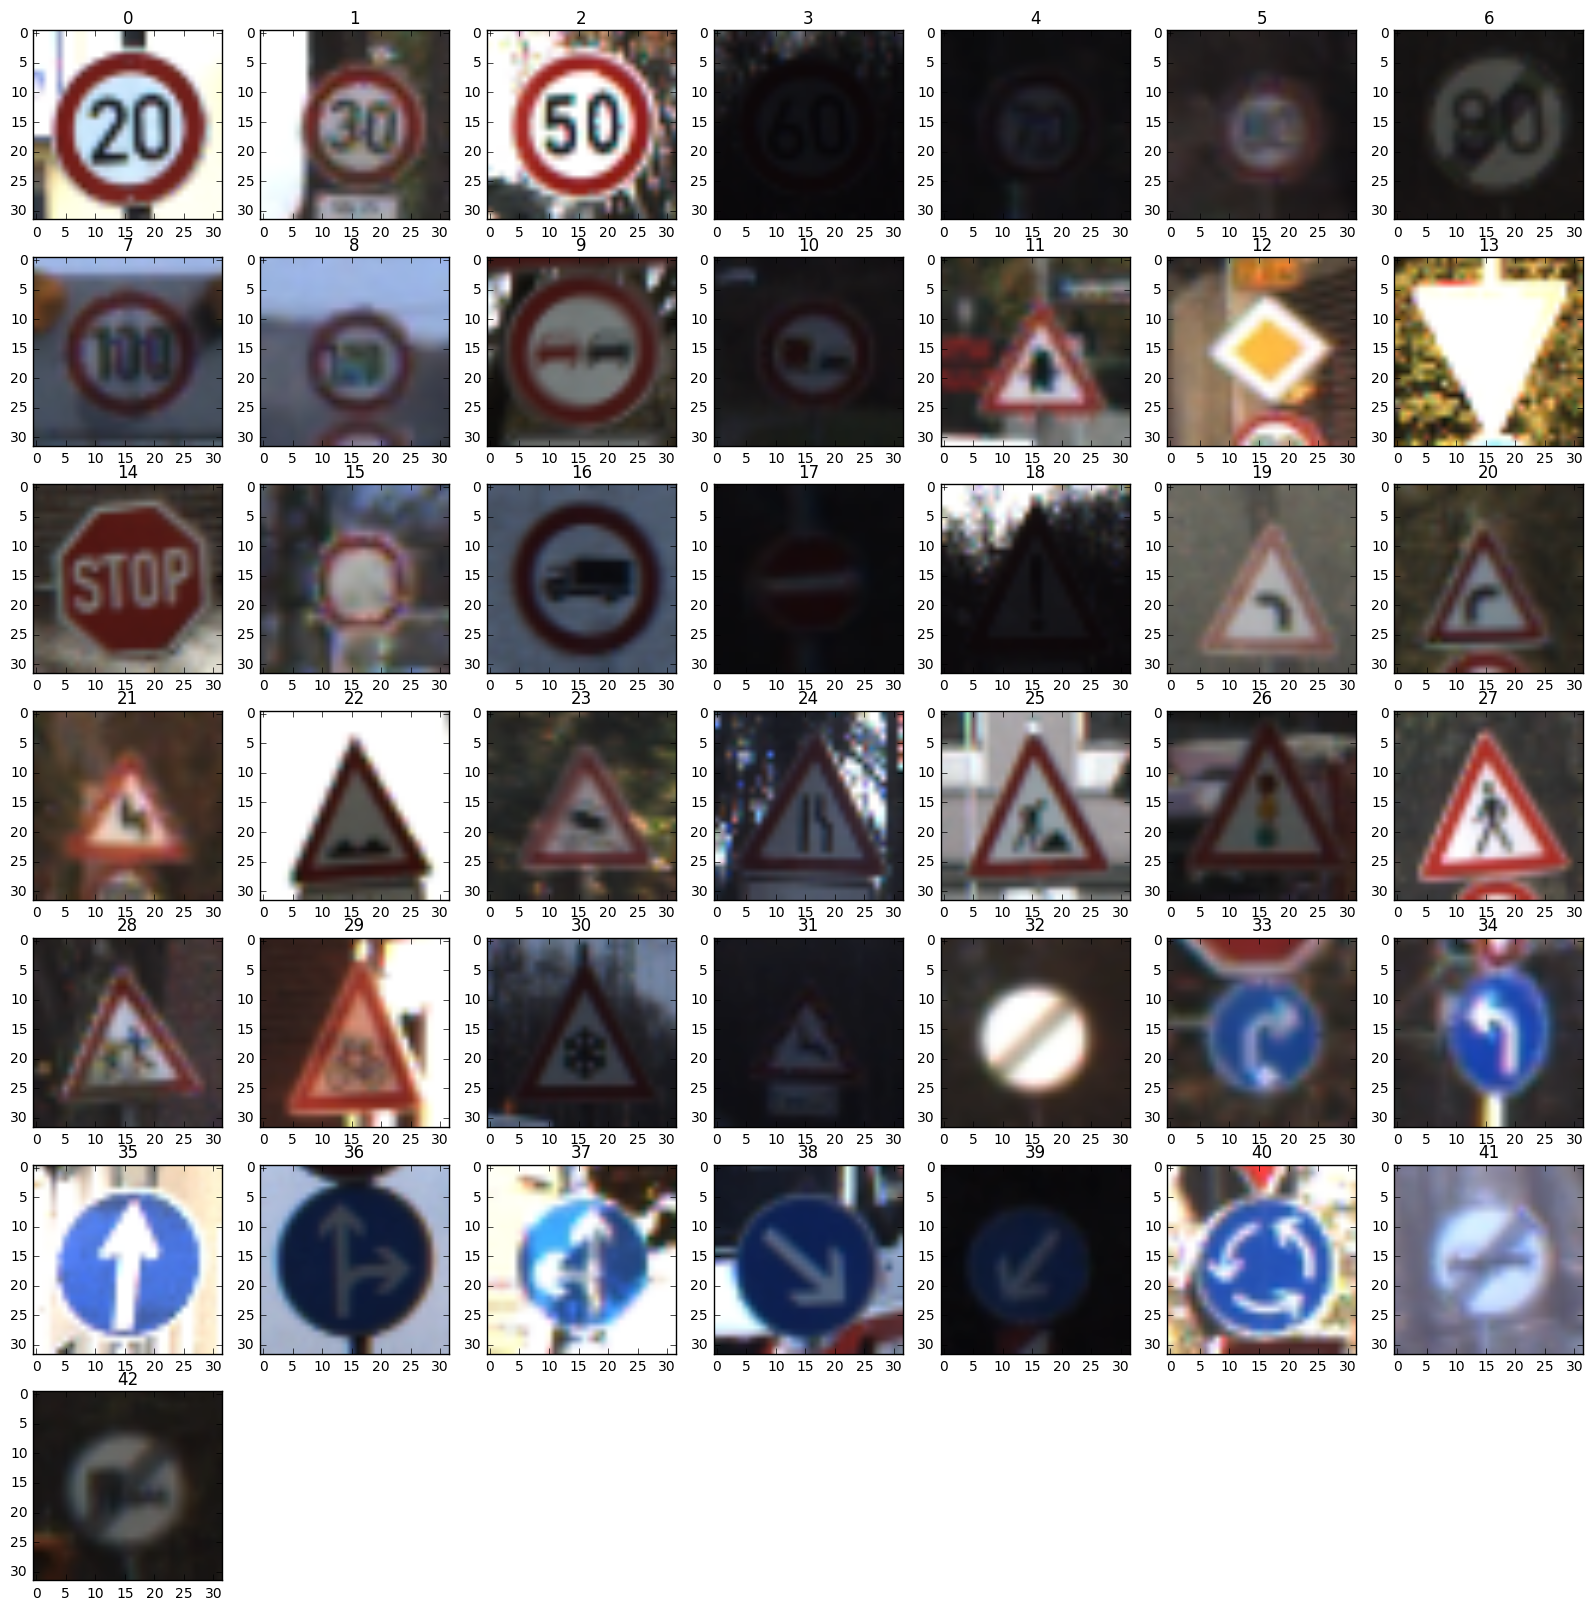

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(43):
    plt.subplot(7,7,i+1) 
    
    ii = np.where(y_train== i)[0]
    plt_image = X_train[ii[int(np.random.random()*len(ii))]].squeeze()
    plt.title(i)
    plt.imshow(plt_image)

(0, 43)

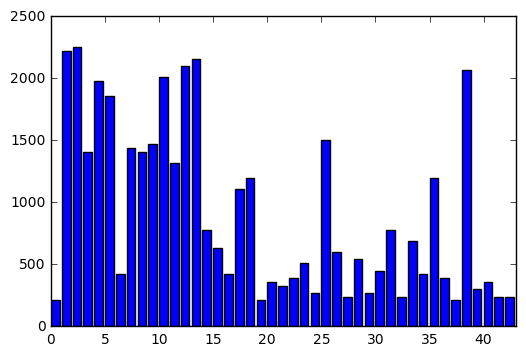

In [5]:
from collections import Counter

plt.bar(Counter(y_train).keys(), Counter(y_train).values())
plt.xlim(0, 43)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.examples.tutorials.mnist import input_data
import cv2
def generate_fake_sample(fake_y_value):
    '''
    INPUT:
    X - your oversampled data
    
    OUTPUT:
    random_sample_X, fake_y_lable
    '''
    
    mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
    X_fake = mnist.test.images[:3000]
    X_fake = np.pad(X_fake, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_fake = np.resize(X_fake, (3000,32,32,3))
    return X_fake, fake_y_value*np.ones(X_fake.shape[0])
def oversample(X, y):
    """
    INPUT:
    X, y - your data

    OUTPUT:
    X,y - oversampled data
    `oversample` randomly replicates observations
    in X, y to achieve equal portion in each label
    """
    target_count = Counter(y).most_common()[0][1]
    X_resampled = X.copy()
    y_resampled = y.copy()
    for y_value, y_count in Counter(y).most_common():
        number_of_new_observations = target_count - y_count
        obs_indices = np.where(y==y_value)[0]
        new_obs_indices = np.random.choice(obs_indices, 
                                       size=number_of_new_observations, 
                                       replace=True)
        X_new, y_new = X[new_obs_indices], y[new_obs_indices]
        X_resampled = np.vstack((X_resampled, X_new))
        y_resampled = np.concatenate((y_resampled,y_new))
    return X_resampled, y_resampled

def shuffle_train_data(X_t,y_t):
    return shuffle(X_t,y_t)


#default sampling has similar accuracy but oversampling is a bit better.
# X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size = 0.2)

X_oversampled, y_oversampled = oversample(X_train, y_train)
# X_fake, y_fake = generate_fake_sample(43)
# X_resampled = np.vstack((X_oversampled, X_fake))
# y_resampled = np.concatenate((y_fake, y_oversampled))

#Fake data does not work too great in this case
#X_t, X_v, y_t, y_v = train_test_split(X_resampled, y_resampled, test_size = 0.2)

#best with oversample only so far
X_t, X_v, y_t, y_v = train_test_split(X_oversampled, y_oversampled, test_size = 0.2)


In [7]:
# print('original size: ', y_train.shape[0], 'new size: ', y_resampled.shape[0])
# plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
# plt.xlim(0, 44)

## Setup TensorFlow and Implement LeNet
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.


In [8]:
import tensorflow as tf

EPOCHS = 200
BATCH_SIZE = 128

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since images are rbg, C is 3 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 44 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [9]:
from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.1
weights = {'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
          'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16],mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal([5*5*16, 120],mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84],mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal([84, 44],mean = mu, stddev = sigma))}
biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bd1': tf.Variable(tf.zeros([120])),
    'bd2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([44]))}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    #new_height = (input_height - filter_height)/S + 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # TODO: Activation.
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    # TODO: Layer 2: Convolutional. Output = 10x10x16.    
    # TODO: Activation.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1   = flatten(conv2)
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 44.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])

    return logits

In [10]:
# from tensorflow.contrib.layers import flatten

# def LeNet(x):    
#     # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
#     mu = 0
#     sigma = 0.1
    
#     # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
#     conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
#     conv1_b = tf.Variable(tf.zeros(6))
#     conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

#     # SOLUTION: Activation.
#     conv1 = tf.nn.relu(conv1)

#     # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
#     conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

#     # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
#     conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
#     conv2_b = tf.Variable(tf.zeros(16))
#     conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
#     # SOLUTION: Activation.
#     conv2 = tf.nn.relu(conv2)

#     # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
#     conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

#     # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
#     fc0   = flatten(conv2)
    
#     # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
#     fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
#     fc1_b = tf.Variable(tf.zeros(120))
#     fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
#     # SOLUTION: Activation.
#     fc1    = tf.nn.relu(fc1)

#     # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
#     fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
#     fc2_b  = tf.Variable(tf.zeros(84))
#     fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
#     # SOLUTION: Activation.
#     fc2    = tf.nn.relu(fc2)

#     # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
#     fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 44), mean = mu, stddev = sigma))
#     fc3_b  = tf.Variable(tf.zeros(44))
#     logits = tf.matmul(fc2, fc3_W) + fc3_b
    
#     return logits

## Features and Labels
Train LeNet to classify traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 44)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [12]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


In [14]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_t)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_t, y_t = shuffle(X_t, y_t)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_t[offset:end], y_t[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_v, y_v)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.909

EPOCH 2 ...
Validation Accuracy = 0.957

EPOCH 3 ...
Validation Accuracy = 0.968

EPOCH 4 ...
Validation Accuracy = 0.972

EPOCH 5 ...
Validation Accuracy = 0.976

EPOCH 6 ...
Validation Accuracy = 0.984

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.983

EPOCH 9 ...
Validation Accuracy = 0.981

EPOCH 10 ...
Validation Accuracy = 0.986

EPOCH 11 ...
Validation Accuracy = 0.988

EPOCH 12 ...
Validation Accuracy = 0.987

EPOCH 13 ...
Validation Accuracy = 0.988

EPOCH 14 ...
Validation Accuracy = 0.989

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.986

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.992

EPOCH 19 ...
Validation Accuracy = 0.973

EPOCH 20 ...
Validation Accuracy = 0.990

EPOCH 21 ...
Validation Accuracy = 0.989

EPOCH 22 ...
Validation Accuracy = 0.991

EPOCH 23 ...
Validation Accuracy = 0.990

EPOCH 24 ...
Validation Accura

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.930


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [16]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
'''
I loaded and confirmed data shape, and plotted images for visualization. 
I used over_sampling to generate additional data to make the count of each label equally. 
In addition, I created fake data to prevent overfitting.
I chose train_test_split to split the training data to 80% train data and 20% valid data.  
'''

'\nI loaded and confirmed data shape, and plotted images for visualization. \nI used over_sampling to generate additional data to make the count of each label equally. \nIn addition, I created fake data to prevent overfitting.\nI chose train_test_split to split the training data to 80% train data and 20% valid data.  \n'

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
'''
I genreated additional data with oversampling and fake data with random sampling approx. 6000 data point. 
These random data can help to prevent overfitting.
I make sure each data label have the same count number as the most common label.
The new dataset is bigger than the orignal one since I ovsersampled the undersize data.
I used sklearn library for train_split test to create
'''

'\nI genreated additional data with oversampling and fake data with random sampling approx. 6000 data point. \nThese random data can help to prevent overfitting.\nI make sure each data label have the same count number as the most common label.\nThe new dataset is bigger than the orignal one since I ovsersampled the undersize data.\nI used sklearn library for train_split test to create\n'

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
EPOCHS = 200,
BATCH_SIZE = 128,
rate = 0.001,
optimizer = AdamOptimizer,
loss_operation  = soft_max_entropy_with_logits

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

LeNet is great implementation for trainning 32x32 size images. I just replaced the imput layer and output layer size to match the need for this traffic sign classfiication.  I have tried different layer size and tuned the parameters with the best validated accuracy.  

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
web_image = 

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.